In [1]:
# general imports
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import wandb
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator
from upt.datasets.ffs_dataset import ffsDataset

In [2]:
# check successful setup
print(torch.__version__)
device = torch.device("cuda")
print(torch.cuda.get_device_name(device))
import torchvision
print(torchvision.__version__)
from torch_geometric.nn.pool import radius_graph
from torch_scatter import segment_csr



2.5.1+cu124
NVIDIA GeForce GTX 970
0.20.1+cu124


# RANS FFS

In [3]:
# hyperparameters model
dim = 256
num_heads = 4
radius = 5
max_degree=32
depth=4
num_latent_tokens=512

# hyperparameters training
learning_rate = 1e-4
weight_decay=0.05
num_supernodes = 512
epochs = 1000
batch_size = 50

runID = 'SDF_600s_crop+-5'

Datasets

In [4]:
from upt.datasets.ffs_dataset import ffsDataset

num_test_inputs  = 4096
num_test_outputs = 4096
# num_train_inputs  = 8192
# num_train_outputs = 16000

num_train_inputs  = num_test_inputs 
num_train_outputs = num_test_outputs

crop_values= [[-5, -2], [5, 2]]

# initialize dataset
train_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_train_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_train_outputs,
    # mode
    mode="train",
    # crop
    crop_values= crop_values,
)

test_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=num_test_inputs,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=num_test_outputs,
    # mode
    mode="test",
    # crop
    crop_values= crop_values,
)


Dataloaders

In [5]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from upt.collators.ffs_collator import ffsCollator

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=False),
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    collate_fn=ffsCollator(num_supernodes=num_supernodes, deterministic=True),
)

Model

In [6]:
from upt.models.ffs_upt import ffsUPT
# from upt.models.upt import UPT
from upt.models.approximator import Approximator
from upt.models.decoder_perceiver import DecoderPerceiver
from upt.models.encoder_supernodes import EncoderSupernodes
from upt.models.conditioner_re import ConditionerRe

# initialize model
conditioner = ConditionerRe(
    dim=dim,
    num_values=train_dataset.num_values,
)
model = ffsUPT(
    conditioner=conditioner,
    encoder=EncoderSupernodes(
        # simulation has 1 input sdf
        input_dim=1,
        # 2D dataset
        ndim=2,
        # positions are rescaled to [0, 200]
        radius=radius,
        # in regions where there are a lot of mesh cells, it would result in supernodes having a lot of
        # connections to nodes. but since we sample the supernodes uniform, we also have a lot of supernodes
        # in dense regions, so we can simply limit the maximum amount of connections to each supernodes
        # to avoid an extreme amount of edges
        max_degree=max_degree,
        # dimension for the supernode pooling -> use same as ViT-T latent dim
        gnn_dim=dim,
        # ViT-T latent dimension
        enc_dim=dim,
        enc_num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        enc_depth=depth,
        # downsample to 128 latent tokens for fast training
        perc_dim=dim,
        perc_num_heads=num_heads,
        num_latent_tokens=num_latent_tokens,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    approximator=Approximator(
        # tell the approximator the dimension of the input (perc_dim or enc_dim of encoder)
        input_dim=dim,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
    decoder=DecoderPerceiver(
        # tell the decoder the dimension of the input (dim of approximator)
        input_dim=dim,
        # 2D velocity + pressure
        output_dim=3,
        # simulation is 2D
        ndim=2,
        # as in ViT-T
        dim=dim,
        num_heads=num_heads,
        # ViT-T has 12 blocks -> parameters are split evenly among encoder/approximator/decoder
        depth=depth,
        # we assume num_outputs to be constant so we can simply reshape the dense result into a sparse tensor
        unbatch_mode="dense_to_sparse_unpadded",
        # pass conditioner dim
        cond_dim=conditioner.cond_dim,
    ),
)
model = model.to(device)
print(f"parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.1f}M")

parameters: 34.9M


WandB Init

In [7]:
# # Start a new wandb run to track this script.
# run = wandb.init(
#     # Set the wandb entity where your project will be logged (generally your team name).
#     entity="battlejacket-liu",
#     name=runID,
#     # Set the wandb project where this run will be logged.
#     project="UPT-DO",
#     # Track hyperparameters and run metadata.
#     config={
#         "learning_rate": learning_rate,
#         "dataset": "ffs",
#         "epochs": epochs,
#         "num_test_inputs": num_test_inputs,
#         "num_test_outputs": num_test_outputs,
#         "num_train_inputs": num_train_inputs,
#         "num_train_outputs": num_train_outputs,
#         "dim": dim,
#         "num_heads": num_heads,
#         "batch_size": batch_size,
#         "weight_decay": weight_decay,
#         "num_supernodes": num_supernodes,
#         "depth": depth,
#         "encoder_radius": radius,
#         "encoder_max_degree": max_degree,
#         "encoder_num_latent_tokens": num_latent_tokens,
#     },
# )

Train Model

In [8]:
# # initialize optimizer and learning rate schedule (linear warmup for first 10% -> linear decay)
# optim = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# total_updates = len(train_dataloader) * epochs
# warmup_updates = int(total_updates * 0.1)
# lrs = torch.concat(
#     [
#         # linear warmup
#         torch.linspace(0, optim.defaults["lr"], warmup_updates),
#         # linear decay
#         torch.linspace(optim.defaults["lr"], 0, total_updates - warmup_updates),
#     ],
# )

# # train model
# update = 0
# pbar = tqdm(total=total_updates)
# pbar.update(0)
# pbar.set_description("train_loss: ????? train_accuracy: ????% test_accuracy: ????%")
# test_accuracy = 0.0
# train_losses = []
# test_losses = []
# loss = None
# test_loss = None
# for _ in range(epochs):
#     # train for an epoch
#     for batch in train_dataloader:
#         # schedule learning rate
#         for param_group in optim.param_groups:
#             param_group["lr"] = lrs[update]

#         # forward pass
#         y_hat = model(
#             input_feat=batch["input_feat"].to(device),
#             # input_feat=None,
#             input_pos=batch["input_pos"].to(device),
#             supernode_idxs=batch["supernode_idxs"].to(device),
#             batch_idx=batch["batch_idx"].to(device),
#             output_pos=batch["output_pos"].to(device),
#             re=batch["re"].to(device),

#         )
#         y = batch["target_feat"].to(device)
#         assert y_hat.shape == y.shape
#         loss = F.mse_loss(y_hat, y)

#         # backward pass
#         loss.backward()

#         # update step
#         optim.step()
#         optim.zero_grad()

#         # status update
#         update += 1
#         pbar.update()
#         if test_loss is None:
#             pbar.set_description(f"train_loss: {loss.item():.4f}")
#         else:
#             pbar.set_description(
#                 f"train_loss: {loss.item():.4f} "
#                 f"test_loss: {test_loss:.4f} "
#             )
#         train_losses.append(loss.item())

#     # evaluate
#     test_loss = 0.
#     for batch in test_dataloader:
#         with torch.no_grad():
#             y_hat = model(
#                 input_feat=batch["input_feat"].to(device),
#                 # input_feat=None,
#                 input_pos=batch["input_pos"].to(device),
#                 supernode_idxs=batch["supernode_idxs"].to(device),
#                 batch_idx=batch["batch_idx"].to(device),
#                 output_pos=batch["output_pos"].to(device),
#                 re=batch["re"].to(device),
#             )
#         y = batch["target_feat"].to(device)
#         test_loss += (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
#     test_loss /= len(test_dataloader)
#     test_losses.append(test_loss)
#     pbar.set_description(
#         f"train_loss: {loss.item():.4f} "
#         f"test_loss: {test_loss:.4f} "
#     )
#     wandb.log(
#         {
#             "train_loss": loss.item(),
#             "test_loss": test_loss,
#             "learning_rate": optim.param_groups[0]["lr"],
#         }
#     )
# pbar.close()

Save & Load Model

In [9]:
# path = 'save/' + runID + '.pth'
# torch.save(model.state_dict(), path)
# # wandb.save('save/sdf_model.pth')

In [10]:
path = 'save/' + runID + '.pth'
model.load_state_dict(torch.load(path, weights_only=True))
model.eval()

ffsUPT(
  (conditioner): ConditionerRe(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): SiLU()
    )
    (re_embed): ContinuousSincosEmbed(dim=256)
  )
  (encoder): EncoderSupernodes(
    (supernode_pooling): SupernodePooling(
      (input_proj): LinearProjection(
        (proj): Linear(in_features=1, out_features=256, bias=True)
      )
      (pos_embed): ContinuousSincosEmbed(dim=256)
      (message): Sequential(
        (0): LinearProjection(
          (proj): Linear(in_features=512, out_features=256, bias=True)
        )
        (1): GELU(approximate='none')
        (2): LinearProjection(
          (proj): Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
    (enc_proj): LinearProjection(
      (proj): Identity()
    )
    (blocks): Sequential(
      (0): DitBlock(
        (modulation): Dit(
          (modulation): Linear(in_features=1024, out_features=1536, bias=True)
        )
        (norm1): LayerNorm

Test and Inference

In [11]:
# crop_values_test= [[-2, -2], [0, 2]]

test_hr_dataset = ffsDataset(
    root="./data/ffs/preprocessed600",
    # how many inputs to use for training
    # num_inputs=float("inf"),
    num_inputs=10000,
    # how many outputs to use for training
    # num_outputs=float("inf"),
    num_outputs=10000,
    # mode
    mode="test",
    crop_values=crop_values,
    useMesh='modify',
    use_inferencer_inputs=False
)
from torch.utils.data import DataLoader
from upt.collators.ffs_collator import ffsCollator

# get test sample
test_dataloader = DataLoader(
    dataset=test_hr_dataset,
    batch_size=1,
    collate_fn=ffsCollator(num_supernodes=1024, deterministic=True),
)
data = [d for d in test_dataloader]

In [12]:
test_batch = data[0]
name = test_batch['name'][0]
paramDef = {'name': str, 're': float, 'Lo': float, 'Ho': float}
from data.ffs.readParameters import readParametersFromFileName
parameters = readParametersFromFileName(name, paramDef)
re = parameters['re']
Lo = parameters['Lo']
Ho = parameters['Ho']

In [13]:
# make predictions

with torch.no_grad():
    y_hat = model(
        input_feat=test_batch["input_feat"].to(device),
        input_pos=test_batch["input_pos"].to(device),
        # input_pos=test_hr_dataset.denormalize_pos(points).to(device),
        supernode_idxs=test_batch["supernode_idxs"].to(device),
        batch_idx=test_batch["batch_idx"].to(device),
        output_pos=test_batch["output_pos"].to(device),
        re=test_batch["re"].to(device),
    )

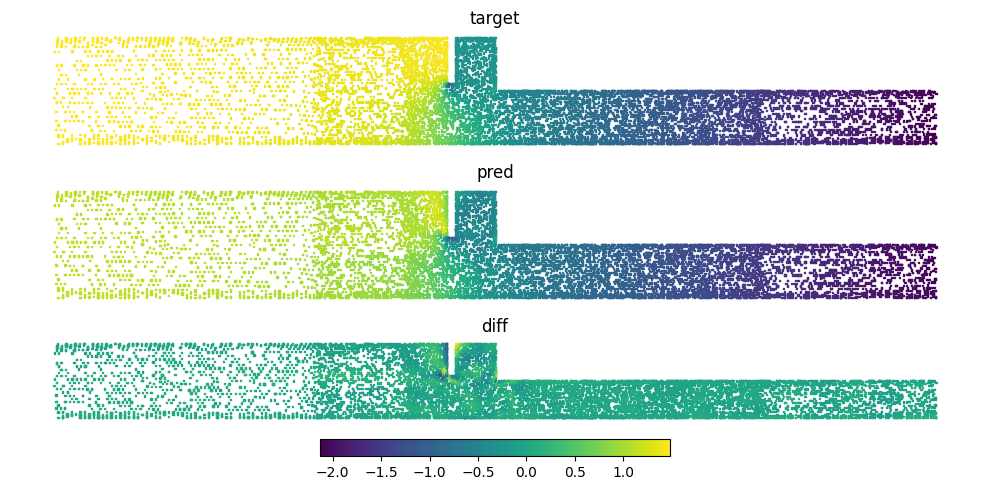

In [14]:
# generated input vs target
points = test_hr_dataset.denormalize_pos(test_batch["output_pos"].squeeze(0))
pred_all = test_hr_dataset.denormalize_feat(y_hat.cpu())

feature_idx = 2

x_pos, y_pos = points.unbind(1)
pred = pred_all[:,feature_idx]
target_all = test_hr_dataset.denormalize_feat(test_batch["target_feat"]) #[:10000]
target = target_all[:,feature_idx]


_, axes = plt.subplots(3, 1, figsize=(10, 5)) #, figsize=(10, 2)
axes[0].scatter(x_pos, y_pos, c=target, marker="s", s=1)
axes[0].set_title("target")
axes[0].set_axis_off()
axes[1].scatter(x_pos, y_pos, c=pred, marker="s", s=1)
axes[1].set_title("pred")
axes[1].set_axis_off()
scatter_diff = axes[2].scatter(x_pos, y_pos, c=pred-target, marker="s", s=1)
axes[2].set_title("diff")
axes[2].set_axis_off()
plt.colorbar(scatter_diff, ax=axes[2], orientation="horizontal")
plt.tight_layout()
# plt.colorbar()
# plt.title(test_batch["name"])
plt.show()

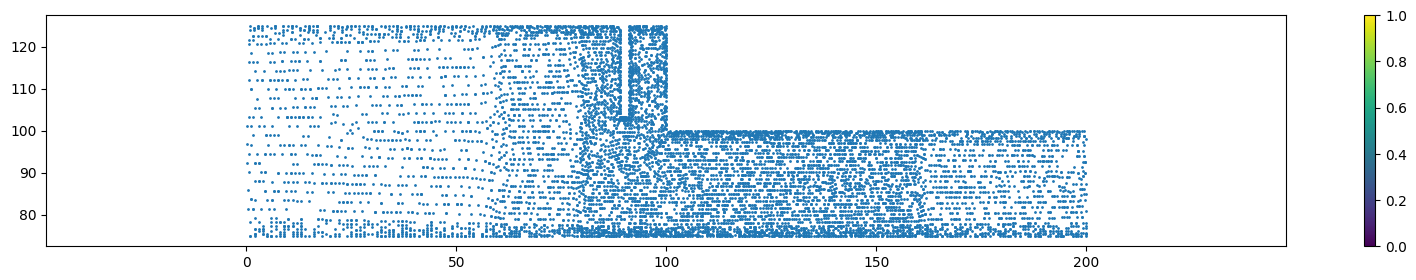

In [15]:
# generated input vs target
idx = 0
points = test_hr_dataset[0]["input_pos"]

x_pos, y_pos = points.unbind(1)

# Visualize
plt.figure(figsize=(20, 3))
plt.scatter(x_pos, y_pos, marker="o", s=1)
plt.colorbar()
plt.axis("equal")
plt.show()


In [ ]:
train_losses = []
test_losses = []
loss = None
test_loss = None
# # evaluate
test_loss = 0.
for batch in test_dataloader:
    with torch.no_grad():
        y_hat = model(
            input_feat=batch["input_feat"].to(device),
            # input_feat=None,
            input_pos=batch["input_pos"].to(device),
            supernode_idxs=batch["supernode_idxs"].to(device),
            batch_idx=batch["batch_idx"].to(device),
            output_pos=batch["output_pos"].to(device),
            re=batch["re"].to(device),
        )
    y = batch["target_feat"].to(device)
    # test_loss = (F.mse_loss(y_hat, y, reduction="sum") / y.numel()).item()
    test_loss = (F.l1_loss(y_hat, y, reduction="sum") / y.numel()).item()
    test_losses.append(test_loss)


In [21]:
test_loss = np.mean(test_losses)
print(f"test_loss: {test_loss:.4f} ")

test_loss: 0.0253 


In [23]:
from ffsInference import ffsInference

inferencer = ffsInference(
    base_dataset=test_hr_dataset,
    numSupernodes=512,
    model=model,
    device=device,
)

In [38]:
from forwardFacingStep.optimization import deltaCp
from scipy.stats import spearmanr
import pandas as pd

# Load the CSV file
df = pd.read_csv('forwardFacingStep/validationTable.csv')

# Extract the desired columns
selected_columns = ['P4 - Re', 'P6 - Ob_pos [m]', 'P7 - Ob_H [m]', 'P1 - Delta Cp']
dCp_valDesigns = df[selected_columns].to_numpy()

deltaCp = deltaCp()
output_pos = deltaCp.outputPositions()
parameter_sets = dCp_valDesigns[:,:-1]
dCp_true = dCp_valDesigns[:,-1]

#infer using design[:,:-1]
results = inferencer.infer(parameter_sets=parameter_sets, output_pos=output_pos, batch_size=10)
predictions = results['predictions']
dCp_pred = deltaCp.calculateDeltaCp(predictions=predictions)
print(dCp_pred)

#compare with design[:,-1]
# Compute Spearman's rank correlation coefficient and p-value
rho, p_value = spearmanr(dCp_pred, dCp_true)
print(dCp_true)
print(f"Spearman's rho: {rho:.3f}, p-value: {p_value:.3g}")

tensor([ 9.5916, 10.4890,  9.0323, 16.9238, 11.1112, 10.2479, 11.3964, 10.2784,
         9.8100,  9.4004, 13.3485, 10.0850, 12.3886,  9.3892, 15.6923, 11.7248,
         9.4120, 14.2318, 18.3986, 10.5337, 10.4224,  9.0542,  9.4139, 11.3393])
[ 9.20468 10.3956   8.86085 17.385   10.9893  10.0252  11.307   10.1086
  9.59227  9.12251 13.4272   9.88638 12.5777   9.1743  16.1458  11.8982
  9.26832 14.5889  18.9848  10.5454  10.3917   8.96592  9.34061 11.7781 ]
Spearman's rho: 0.996, p-value: 3.54e-24


In [26]:
import numpy as np
import time
import os
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.termination.default import DefaultMultiObjectiveTermination
from forwardFacingStep.optimization import ffsOptProblem

param_ranges = {
    'Re': (100, 1000),
    'Lo': (0.2, 1),
    'Ho': (0.1, 0.5),
    }



xl=np.array([float(param_ranges['Lo'][0]),float(param_ranges['Ho'][0])])
xu=np.array([float(param_ranges['Lo'][1]),float(param_ranges['Ho'][1])])

# inferencer = ffsInference(
#     train_dataset=test_hr_dataset,
#     totalPoints=40000,
#     numSupernodes=512,
    
# )

optResultsPath = "./optimizationResults/"

optPath = optResultsPath

# reRange = [600]
reRange = range(100,1100,100)
print('defining problem')

# problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu, inferencer=inferencer, maxDesignsPerEvaluation=500)


for re in reRange:

    if os.path.exists(optPath + "/optResultsX" + str(re) + ".npy"):
        print("skipping ", optPath + " " + str(re))
        continue
    
    optStartTime = time.time()
    
    # print("Optimizing: ", str(model) + " " + str(re))
    print("Optimizing: " + str(re))
    
    # problem.re = re 
    problem = ffsOptProblem(n_var=2,n_obj=1, xl=xl, xu=xu,
                inferencer=inferencer, re=re, maxDesignsPerEvaluation=500)
    algorithm = DE(pop_size=200)

    termination = DefaultMultiObjectiveTermination(
        n_max_gen=1000, # default 1000
        n_max_evals=10000000
    )

    # results = minimize(problem=problem, algorithm=algorithm,termination=termination)

    # # with open("checkpoint", "wb") as f:
    # #     dill.dump(algorithm, f)


    # print("Optimization Done in ", time.time() - optStartTime)
    # print("Best Design Objective Value: ", results.F)
    # print("Best Design Parameter Value: ", results.X)

defining problem
Optimizing: 100
Optimizing: 200
Optimizing: 300
Optimizing: 400
Optimizing: 500
Optimizing: 600
Optimizing: 700
Optimizing: 800
Optimizing: 900
Optimizing: 1000


In [27]:
designs = []
for i in range(3):
    designs.append([600, 0.32, 0.39])
designs = np.array(designs)

In [29]:
# Discrete/Continuous Re, Lo, Ho, dCp, dCp^ref, ddCp
# 600 0.32 0.39 9.94 10.33 0.39
# 600 0.36 0.38 9.94 10.33 0.39

# designs = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38]])
# designs = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38], [700, 0.36, 0.38], [800, 0.36, 0.38]])

allDesigns = designs[:, 1:]
out = {}

prediction = problem._evaluate(allDesigns, out)

Evaluation time: 0.18 seconds


In [30]:
out

{'F': array([8.902159, 8.885717, 8.87254 ], dtype=float32)}

In [30]:
designs = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38], [700, 0.36, 0.38], [800, 0.36, 0.38]])
results_1 = inferencer.infer(parameter_sets=designs, batch_size=1)
results_2 = inferencer.infer(parameter_sets=designs, batch_size=20)
predictions_1 = results_1['predictions']
predictions_2 = results_2['predictions']
print(predictions_1.shape)
print(predictions_2.shape)

torch.Size([40000, 3])
torch.Size([40000, 3])


In [2]:
40000/10000

4.0

In [31]:
allDesigns = np.array([[600, 0.32, 0.39], [600, 0.36, 0.38], [700, 0.36, 0.38], [800, 0.36, 0.38]])
allDesigns = np.array([[600, 0.32, 0.39]])
batch_size=1

# Create points to use for inference, one line upstream and one line downstream of the step
upstreamX = -4
downstreamX = 4
numPoints = 5
upstreamPoints = torch.tensor([[upstreamX, y] for y in np.linspace(-0.5, 0.5, numPoints)], dtype=torch.float32)
downstreamPoints = torch.tensor([[downstreamX, y] for y in np.linspace(-0.5, 0.5, numPoints)], dtype=torch.float32)
points = torch.cat((upstreamPoints, downstreamPoints), dim=0)

# Normalize points
# points = inferencer.base_dataset.normalize_pos(points)

# # Prepare parameter sets
# re_column = np.full((allDesigns.shape[0], 1), self.re)
parameter_sets = allDesigns

# Perform inference
results = inferencer.infer(parameter_sets=parameter_sets, output_pos=points, batch_size=batch_size)
predictions = results['predictions']  # Shape: [num_designs * num_points, 3]

print(predictions.shape)

# Reshape predictions to [num_designs, num_points, 3]
num_designs = allDesigns.shape[0]
num_total_points = points.shape[0]
print(num_designs)
print(num_total_points)
predictions = predictions.reshape(num_designs, num_total_points, -1)

print(predictions.shape)

# Extract pressures
pressures = predictions[:, :, 2]  # Extract the pressure (p) component

# Split into upstream and downstream pressures
upstreamPressures = pressures[:, :numPoints]
downstreamPressures = pressures[:, numPoints:]

# Calculate average pressures
upstreamPressure = upstreamPressures.mean(dim=1)
downstreamPressure = downstreamPressures.mean(dim=1)
        

# Calculate dCp
rho = 1.0
Um = 1.0
dCp = 2 * (upstreamPressure - downstreamPressure) / (rho * Um**2)
# print("dCp: ", dCp)
# valuesF.append(dCp.detach().cpu().numpy())

out = dCp.detach().cpu().numpy() #np.array(valuesF)
print(out)

torch.Size([10, 3])
1
10
torch.Size([1, 10, 3])
[9.885302]


In [39]:
allDesigns = np.array([[600, 0.9, 0.39], [600, 0.36, 0.38], [700, 0.36, 0.38], [800, 0.36, 0.38]])
import copy
inference_dataset = copy.deepcopy(test_hr_dataset)        
inference_dataset.setInferenceMode(allDesigns)
inference_dataset.customOutputPos = points

In [42]:
a = inference_dataset.__getitem__(0)

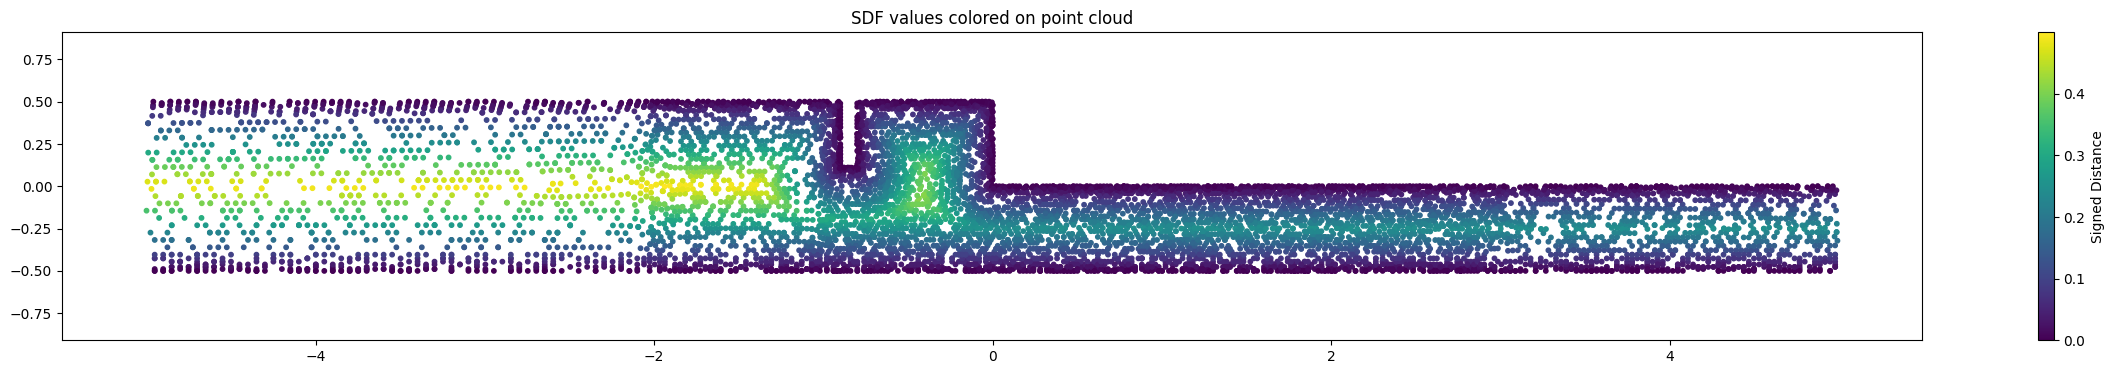

In [43]:
import matplotlib.pyplot as plt
coord = test_hr_dataset.denormalize_pos(a['input_pos'])
var = test_hr_dataset.denormalize_sdf(a['input_feat'])
# var = input_feat
# coord = input_pos
# Visualize
plt.figure(figsize=(30, 4))
plt.scatter(coord[:, 0], coord[:, 1], c=var, s=10)
plt.colorbar(label="Signed Distance")
plt.axis("equal")
plt.title("SDF values colored on point cloud")
plt.show()